## Recommendation To Improve Language Learning

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dot, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
df = pd.read_csv('data.csv')

# Preprocessing
le = LabelEncoder()
categorical_columns = ['category', 'difficulty', 'cultural_context', 'user_country', 'user_age_group', 'user_proficiency']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

df['user_id'] = le.fit_transform(df['user_id'])
df['exercise_id'] = le.fit_transform(df['exercise_id'])

# Create a mapping from exercise_id to cultural_context
exercise_to_context = {
    101: 'Anime',
    102: 'Kpop',
    103: 'Kdrama',
    104: 'Horror',
    105: 'Sitcom',
    106: 'Memes',
    107: 'Sports',
    108: 'Informative'
}

# Splitting the data
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Model parameters
n_users = df['user_id'].nunique()
n_exercises = df['exercise_id'].nunique()
n_factors = 50
n_categories = df['category'].nunique()
n_difficulties = df['difficulty'].nunique()
n_cultural_contexts = df['cultural_context'].nunique()
n_countries = df['user_country'].nunique()
n_age_groups = df['user_age_group'].nunique()
n_proficiencies = df['user_proficiency'].nunique()

# Model architecture
user_input = Input(shape=(1,), name='user_input')
exercise_input = Input(shape=(1,), name='exercise_input')
category_input = Input(shape=(1,), name='category_input')
difficulty_input = Input(shape=(1,), name='difficulty_input')
cultural_context_input = Input(shape=(1,), name='cultural_context_input')
user_country_input = Input(shape=(1,), name='user_country_input')
user_age_group_input = Input(shape=(1,), name='user_age_group_input')
user_proficiency_input = Input(shape=(1,), name='user_proficiency_input')

# Collaborative filtering part
user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6))(user_input)
exercise_embedding = Embedding(n_exercises, n_factors, embeddings_regularizer=l2(1e-6))(exercise_input)
user_vec = Flatten()(user_embedding)
exercise_vec = Flatten()(exercise_embedding)
cf_output = Dot(axes=1)([user_vec, exercise_vec])

# Content-based part
category_embedding = Embedding(n_categories, 10)(category_input)
difficulty_embedding = Embedding(n_difficulties, 5)(difficulty_input)
cultural_context_embedding = Embedding(n_cultural_contexts, 10)(cultural_context_input)
user_country_embedding = Embedding(n_countries, 10)(user_country_input)
user_age_group_embedding = Embedding(n_age_groups, 5)(user_age_group_input)
user_proficiency_embedding = Embedding(n_proficiencies, 5)(user_proficiency_input)

concat = Concatenate()([
    Flatten()(category_embedding),
    Flatten()(difficulty_embedding),
    Flatten()(cultural_context_embedding),
    Flatten()(user_country_embedding),
    Flatten()(user_age_group_embedding),
    Flatten()(user_proficiency_embedding)
])

# More complex ANN architecture
dense1 = Dense(64, activation='relu')(concat)
bn1 = BatchNormalization()(dense1)
dense2 = Dense(32, activation='relu')(bn1)
bn2 = BatchNormalization()(dense2)
dropout1 = Dropout(0.3)(bn2)
dense3 = Dense(16, activation='relu')(dropout1)
bn3 = BatchNormalization()(dense3)
dense4 = Dense(8, activation='relu')(bn3)
bn4 = BatchNormalization()(dense4)
cb_output = Dense(1)(bn4)

# Combine CF and CB outputs
combined_output = Dense(1)(Concatenate()([cf_output, cb_output]))

model = Model(
    inputs=[user_input, exercise_input, category_input, difficulty_input, cultural_context_input, user_country_input, user_age_group_input, user_proficiency_input],
    outputs=combined_output
)

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    [train['user_id'], train['exercise_id'], train['category'], train['difficulty'], train['cultural_context'], train['user_country'], train['user_age_group'], train['user_proficiency']],
    train['rating'],
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Function to get top N recommendations for a user
def get_top_n_recommendations(user_id, n=2):
    user_exercises = df[df['user_id'] == user_id]['exercise_id'].unique()
    all_exercises = df['exercise_id'].unique()
    exercises_to_predict = np.setdiff1d(all_exercises, user_exercises)
    
    if len(exercises_to_predict) == 0:
        return []
    
    user_data = df[df['user_id'] == user_id].iloc[0]
    user_vector = np.array([user_id] * len(exercises_to_predict))
    exercise_vector = exercises_to_predict
    category_vector = np.array([user_data['category']] * len(exercises_to_predict))
    difficulty_vector = np.array([user_data['difficulty']] * len(exercises_to_predict))
    cultural_context_vector = np.array([user_data['cultural_context']] * len(exercises_to_predict))
    user_country_vector = np.array([user_data['user_country']] * len(exercises_to_predict))
    user_age_group_vector = np.array([user_data['user_age_group']] * len(exercises_to_predict))
    user_proficiency_vector = np.array([user_data['user_proficiency']] * len(exercises_to_predict))
    
    predictions = model.predict([user_vector, exercise_vector, category_vector, difficulty_vector, cultural_context_vector, user_country_vector, user_age_group_vector, user_proficiency_vector])
    top_n_indices = predictions.flatten().argsort()[-n:][::-1]
    recommended_exercises = exercises_to_predict[top_n_indices]
    return [exercise_to_context.get(ex + 101, 'Unknown') for ex in recommended_exercises]

# Cold start strategy
def cold_start_recommendation(user_data, n=2):
    # For new users, recommend based on their proficiency level and country
    similar_users = df[
        (df['user_proficiency'] == user_data['user_proficiency']) &
        (df['user_country'] == user_data['user_country'])
    ]
    
    if len(similar_users) == 0:
        # If no similar users found, recommend popular exercises
        popular_exercises = df.groupby('exercise_id')['rating'].mean().sort_values(ascending=False)
        recommended_exercises = popular_exercises.head(n).index.tolist()
    else:
        # Recommend exercises popular among similar users
        popular_exercises = similar_users.groupby('exercise_id')['rating'].mean().sort_values(ascending=False)
        recommended_exercises = popular_exercises.head(n).index.tolist()
    
    return [exercise_to_context.get(ex + 101, 'Unknown') for ex in recommended_exercises]

# Example usage for existing user
user_id = 0  # Assuming user IDs start from 0 after encoding
top_recommendations = get_top_n_recommendations(user_id, n=2)
print(f"Top exercise recommendations for user {user_id}: {top_recommendations}")

# Example usage for cold start (new user)
new_user_data = {
    'user_proficiency': df['user_proficiency'].mode().iloc[0],  # Most common proficiency
    'user_country': df['user_country'].mode().iloc[0]  # Most common country
}
cold_start_recs = cold_start_recommendation(new_user_data)
print(f"Cold start recommendations: {cold_start_recs}")

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 14.4900 - accuracy: 0.0000e+00 - val_loss: 16.9207 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 31ms/step - loss: 14.0225 - accuracy: 0.0000e+00 - val_loss: 16.9375 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 36ms/step - loss: 13.9256 - accuracy: 0.0000e+00 - val_loss: 16.9122 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 39ms/step - loss: 13.6177 - accuracy: 0.0000e+00 - val_loss: 16.8415 - val_accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 31ms/step - loss: 13.1352 - accuracy: 0.0000e+00 - val_loss: 16.7657 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 33ms/step - loss: 12.9118 - accuracy: 0.0000e+00 - val_loss: 16.6951 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 30ms/step - loss: 13.2051 - accuracy: 0.0000e+00

### Evalution

In [15]:
# Convert test data to numpy arrays
user_id_test = np.array(test['user_id'])
exercise_id_test = np.array(test['exercise_id'])
category_test = np.array(test['category'])
difficulty_test = np.array(test['difficulty'])
cultural_context_test = np.array(test['cultural_context'])
user_country_test = np.array(test['user_country'])
user_age_group_test = np.array(test['user_age_group'])
user_proficiency_test = np.array(test['user_proficiency'])

# Predict on test data
test_predictions = model.predict([
    user_id_test,
    exercise_id_test,
    category_test,
    difficulty_test,
    cultural_context_test,
    user_country_test,
    user_age_group_test,
    user_proficiency_test
])

# Calculate MSE and RMSE
mse = mean_squared_error(test['rating'], test_predictions)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")

1/1 [==============================] - 0s 114ms/step
Test MSE: 1.1274836859874313
Test RMSE: 1.0618303470834836


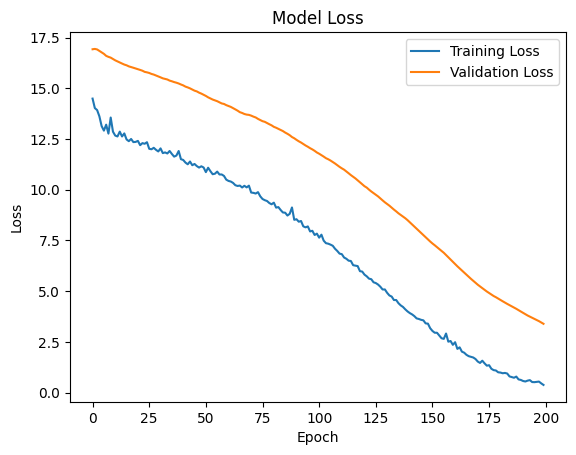

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
